In this project, we will try to analyze multivariate time series I obtained from [kaggle](https://www.kaggle.com/datasets/kaustubhrastogi17/sewa-energy-demand-forecasting) about one year of electricity consumption. Also we will use some machine learning models to create prediction and anlysize all of it's performance. In order to get better understanding of the model and for educational purposes, maybe you can find one or two unreasonable adjustment of the data (you'll understand while looking at it). Hope you enjoy!

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import datetime as dt
import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings('ignore')

# 1. Data Reading

In [178]:
df = pd.read_csv('SEWA_energy.csv')
df.head()

,Date,Day,MAX Tem,Min Tem,Max Hum,Min Hum,Temp,Hum,SEWA MIN LOAD(MW),SEWA Peak Load(MW),SEWA Energy/hr.
0,01-Jan,Friday,28 C,16 C,79%,35%,19 C,50%,652.0,812,734.0
1,02-Jan,Saturday,28 C,14 C,76%,21%,19 C,42%,643.0,936,802.0
2,03-Jan,Sunday,27 C,12 C,74%,25%,20 C,36%,682.0,949,820.0
3,04-Jan,Monday,27 C,12 C,73%,14%,17 C,16%,653.0,942,801.0
4,05-Jan,Tuesday,27 C,10 C,63%,9%,16 C,13%,647.0,925,786.0


General information of data

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                365 non-null    object 
 1   Day                 365 non-null    object 
 2   MAX Tem             362 non-null    object 
 3   Min Tem             362 non-null    object 
 4   Max Hum             362 non-null    object 
 5   Min Hum             362 non-null    object 
 6   Temp                363 non-null    object 
 7   Hum                 363 non-null    object 
 8   SEWA MIN LOAD(MW)   363 non-null    float64
 9   SEWA Peak Load(MW)  365 non-null    int64  
 10  SEWA Energy/hr.     363 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 31.5+ KB


Total of missing value in each column

# 2. Data Preparation

#### Renaming column name

In [180]:
old_col = df.columns[2:]
new_col = ['Max_temp', 'Min_temp', 'Max_hum', 'Min_hum', 'Avg_temp', 'Avg_hum', 'Min_laod', 'Max_load', 
           'Load_per_hour']

# Create pair of old column and new column name
rename_col = dict(zip(old_col, new_col))

df.rename(columns=rename_col, inplace=True)

#### Removing '#' and '%' from temperature and humidity columns

In [181]:
# Get columns name
col_list = ['Max_temp', 'Min_temp', 'Max_hum', 'Min_hum', 'Avg_temp', 'Avg_hum']

# Create a function to get only number using regular expression
def regex(object):
    if pd.notna(object):
        num = re.findall(r'\d+', object)
        return num
    else: 
        return np.nan

# Apply function
for i in col_list:
    df[i] = df[i].apply(lambda x : pd.Series(regex(x)))

#### Handling missing value

In [182]:
df[df.isna().any(axis=1)]

,Date,Day,Max_temp,Min_temp,Max_hum,Min_hum,Avg_temp,Avg_hum,Min_laod,Max_load,Load_per_hour
362,29-Dec,Wednesday,NaN,NaN,NaN,NaN,20,53,822.0,1060,120.0
363,30-Dec,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
364,31-Dec,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [183]:
# Drop all rows with at least one missing value
df.dropna(inplace=True)

#### Fixing some columns data type

In [184]:
# Convert column 3 until 11 to int64 
col_int = df.columns[2:]

for i in col_int:
    df[i] = pd.to_numeric(df[i])
    
# Convert column date to date time with specific format input
def convert(date):
    format = '%d-%b'
    # Assuming all data was recorded in 2023
    this_year = dt.datetime.today().year
    date_time = dt.datetime.strptime(date, format).replace(year=this_year - 2)
    return date_time

df['Date'] = df['Date'].apply(lambda x : pd.Series(convert(x)))

#### Detect and handling outlier

In [185]:
df.describe()

,Max_temp,Min_temp,Max_hum,Min_hum,Avg_temp,Avg_hum,Min_laod,Max_load,Load_per_hour
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.00000,362.000000,362.000000
mean,35.751381,22.417127,78.908840,23.906077,27.245856,55.886740,1262.91989,1669.718232,1483.314917
std,6.694278,6.750400,44.049267,11.020606,5.787827,38.361827,416.57999,541.453597,480.231512
min,12.000000,6.000000,36.000000,4.000000,15.000000,2.000000,591.00000,806.000000,706.000000
25%,30.000000,17.000000,69.250000,15.000000,22.000000,39.000000,859.75000,1112.750000,1002.500000
50%,37.000000,22.000000,78.000000,23.000000,28.000000,52.000000,1273.00000,1659.000000,1473.500000
75%,42.000000,28.000000,85.750000,32.000000,32.000000,67.000000,1668.75000,2227.000000,1970.000000
max,49.000000,51.000000,881.000000,53.000000,38.000000,647.000000,2124.00000,2487.000000,2212.000000


Columns that are indicated to contain outliers: Max_hum, and Avg_hum

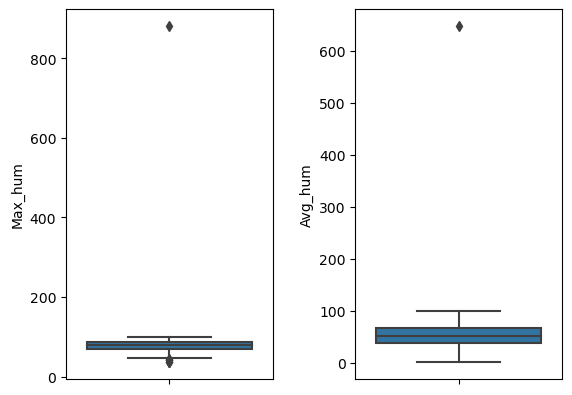

In [186]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(df, y='Max_hum', ax=ax[0])
sns.boxplot(df, y='Avg_hum', ax=ax[1])

plt.subplots_adjust(wspace=0.4)

In [187]:
outlier_idx = df[df['Max_hum'] > 200].index[0]
max_hum_outlier = df['Max_hum'][outlier_idx]
max_hum_outlier

881

In [188]:
outlier_idx = df[df['Avg_hum'] > 200].index[0]
avg_hum_outlier = df['Avg_hum'][outlier_idx]
avg_hum_outlier

647

In [189]:
# Replace outlier with Nan
df = df.replace({'Max_hum':max_hum_outlier}, np.nan)
df = df.replace({'Avg_hum':avg_hum_outlier}, np.nan)

# Using moving average to fill NaN
window = 3
df['Max_hum'] = df['Max_hum'].fillna(df['Max_hum'].rolling(window, min_periods=1).mean())
df['Avg_hum'] = df['Avg_hum'].fillna(df['Avg_hum'].rolling(window, min_periods=1).mean())

#### Feature engineering

Get day of week, and month in numeric format

In [190]:
df['Day_num'] = df['Date'].dt.day_of_week
df['Month_num'] = df['Date'].dt.month

# This data is not representing ordinal data, using numeric as it's data type is a correct approach
df['Day_num'] = df['Day_num'].astype('int64')
df['Month_num'] = df['Month_num'].astype('int64')

# 3. Exploratory Data Analysis

#### Monthly Electricity Consumption

In [191]:
# Get month name from date column
df['Month'] = df['Date'].dt.strftime('%b')
df['Month'] = df['Month'].astype('category')

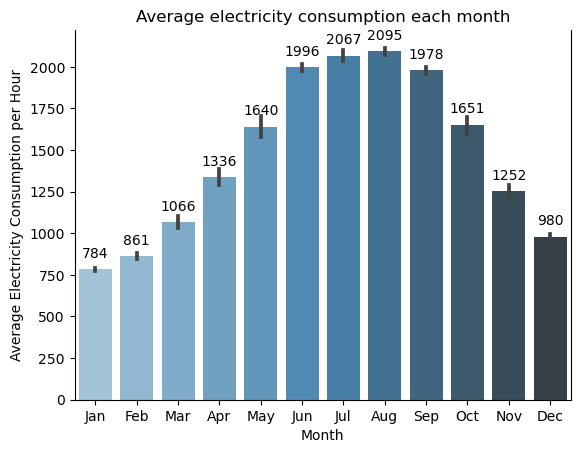

In [192]:
# Create seaborn bar plot
order = list(df['Month'].unique())
plot = sns.barplot(data=df, x='Month', y='Load_per_hour', order=order, palette='Blues_d')
plt.ylabel('Average Electricity Consumption per Hour')
plt.xlabel('Month')
plt.title('Average electricity consumption each month')
plot.spines['top'].set_visible(False)

# Showing number at the top of the plot
# Get detail shape of the plot
for p in plot.patches:
    # Specify text position
    plot.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 70,
        int(p.get_height()),
        ha = 'center'
    )

Highest hourly electricity consumption happened around June until September. It's because in summer, people use more electricity to cooling down house temperature. Also, people spend more time in their home during summer vacation.

#### Daily Electricity Conusumtion

In [193]:
order = list(df['Day'].unique())
order

['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']

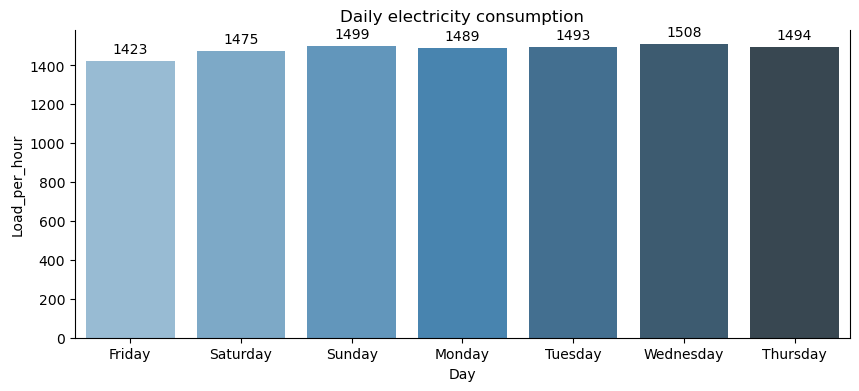

In [194]:
order = list(df['Day'].unique())

daily = df.groupby('Day').mean().reset_index()

plt.figure(figsize=(10, 4))
plot = sns.barplot(daily, x='Day', y='Load_per_hour', order=order, palette='Blues_d')
plt.title('Daily electricity consumption')
plot.spines['top'].set_visible(False)

for p in plot.patches:
    # Specify text position
    plot.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 40,
        int(p.get_height()),
        ha = 'center'
    )

No big different seen in daily electricity consumption.

#### Between teperature and humidity, which factor affect electricity consumption load the most?

In [195]:
# Caculate covariance
df_cov = df[['Avg_temp', 'Load_per_hour', 'Avg_hum']]

# Calculate means
temp_mean = sum(df_cov['Avg_temp']) / len(df_cov)
load_mean = sum(df_cov['Load_per_hour']) / len(df_cov)
hum_mean = sum(df_cov['Avg_hum']) / len(df_cov)

# Substract all value form it's means
df_cov['Temp_sub'] = df_cov['Avg_temp'] - temp_mean
df_cov['Load_sub'] = df_cov['Load_per_hour'] - load_mean
df_cov['Hum_sub'] = df_cov['Avg_hum'] - hum_mean

# Get covariance
# Covariance between temperature and load
cov_temp = sum(df_cov['Temp_sub'] * df_cov['Load_sub']) / (len(df_cov)-1) # We assume we have only sample data

# Covariance between humidity and load
cov_hum = sum(df_cov['Hum_sub'] * df_cov['Load_sub']) / (len(df_cov)-1)

In [196]:
# Calculate standard deviation
temp_stdv = np.std(df_cov['Avg_temp'])
load_stdv = np.std(df_cov['Load_per_hour'])
hum_stdv = np.std(df_cov['Avg_hum'])

In [197]:
pearson_temp = round(cov_temp/(temp_stdv*load_stdv), 3)
pearson_hum = round(cov_hum/(hum_stdv*load_stdv), 3)

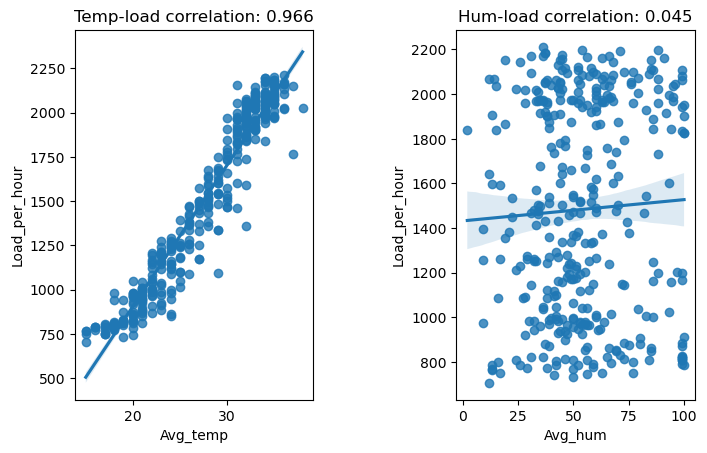

In [198]:
fig, ax = plt.subplots(1, 2)

sns.regplot(data=df, x='Avg_temp', y='Load_per_hour', ax = ax[0])
ax[0].set_title(f'Temp-load correlation: {pearson_temp}')

sns.regplot(data=df, x='Avg_hum', y='Load_per_hour', ax = ax[1])
ax[1].set_title(f'Hum-load correlation: {pearson_hum}')

plt.subplots_adjust(wspace=0.6)
fig.set_figwidth(8)

From plot and pierson correlation coefficient value, temperature affecting total load more than humidity

#### Seasonal Decomposition

In [199]:
dtime = df[['Date', 'Load_per_hour']].set_index('Date')

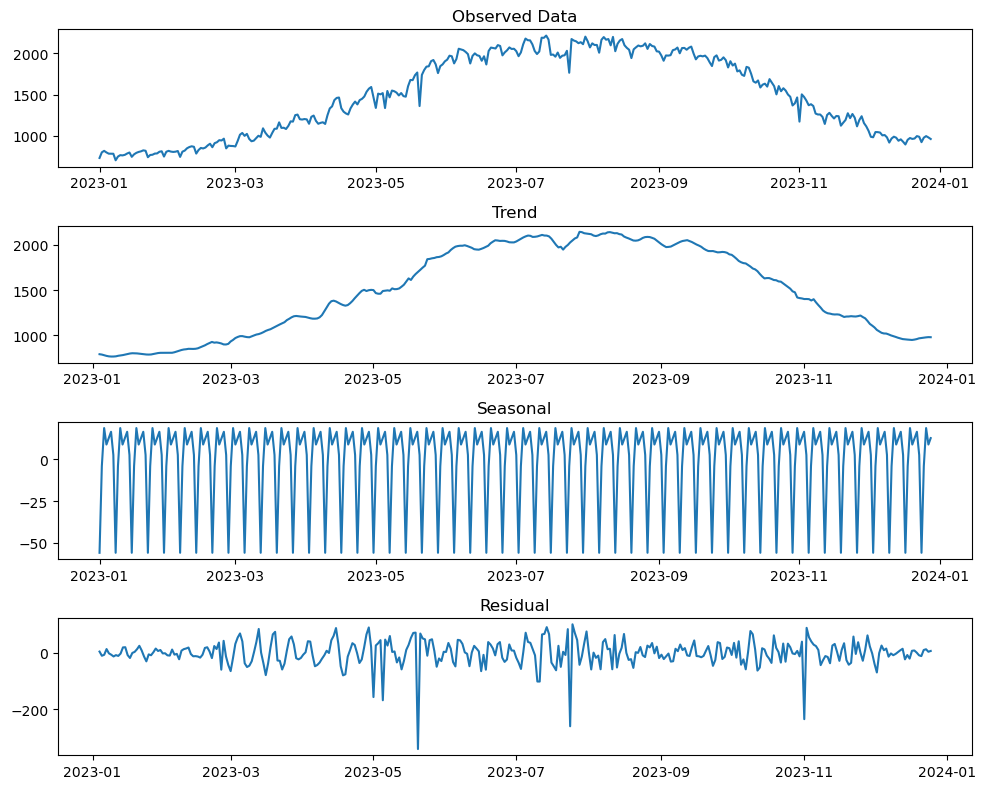

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(dtime, model='additive', period=7)

fig, ax = plt.subplots(4, 1, figsize=(10,8))
ax[0].plot(decomposition.observed)
ax[0].set_title('Observed Data')
ax[1].plot(decomposition.trend)
ax[1].set_title('Trend')
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(decomposition.resid)
ax[3].set_title('Residual')

plt.tight_layout()

From plot above we can get:
- Seasonal pattern of observed data seems same through the time
- Data is not stationer

Hence, we will plot for seasonal adjustment and seasonal differencing.

#### Seasonal Adjustment and Diferencing

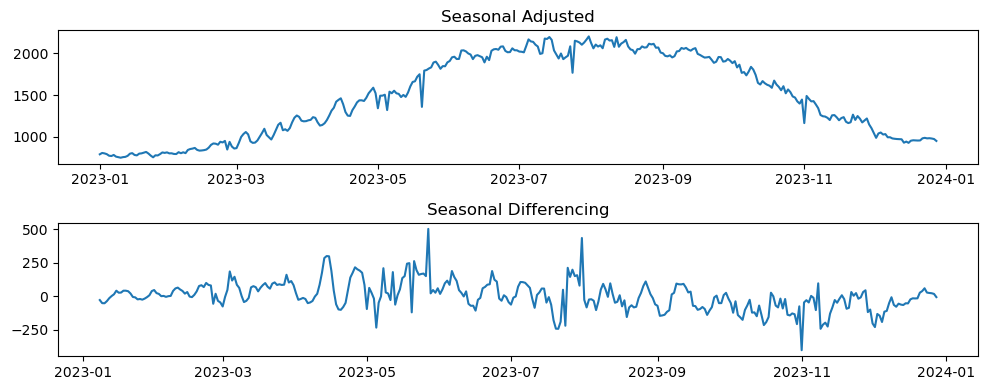

In [201]:
# Seasonal Adjustment
seasonal = decomposition.seasonal

adj_diff = dtime.copy()

# Since our data is additive, we substract original data from it's seasonal.
adj_diff['seaonal_adjusted'] = adj_diff['Load_per_hour'] - seasonal

# Seasonal Differencing
adj_diff['differencing'] = adj_diff['Load_per_hour'].diff(7)

fig, ax = plt.subplots(2, 1, figsize=(10,4))
ax[0].plot(adj_diff['seaonal_adjusted'])
ax[0].set_title('Seasonal Adjusted')
ax[1].plot(adj_diff['differencing'])
ax[1].set_title('Seasonal Differencing')
plt.tight_layout()

Since the data is only a year record, it's hard to see the patter from both seasonal adjusted and seasonal differencing. But two things we can sure to say are summer has the highest electrical consumpton among the year and seasonal effect is not too big to influence the data.

# 4. Model Building

## 1. Linear Regression

`Day_num` is not ordinal (from daily electricity consumption plot above, clearly it's tell us that electricity consuption is not always getting bigger through the week), hence, we use one hot encoding to tell the model that this column is not ordinal.

In [202]:
from sklearn import preprocessing

df['Day_num'] = df['Day_num'].astype('category')

df_lm = df.copy()

day_encoder = pd.get_dummies(df_lm['Day_num'], drop_first=True)
# The data only recorded for a year, so month column will give us no information at all
df_lm.drop(['Day_num', 'Month_num', 'Date', 'Day', 'Month'], axis=1, inplace=True)
df_lm = df_lm.join(day_encoder)

Also, to avoid multicollinearity, we only use average temperature and minimum humidity.

In [203]:
df_lm.drop(['Max_temp', 'Min_temp', 'Max_hum', 'Avg_hum', 'Min_laod', 'Max_load'], axis=1, inplace=True)

### 1.1 Model Assumption

Linear regression model have some model assumptions, they are:
1. Linearity between fitted value with each term in the model.
2. No multicollinearity
3. No heteroscedasticity
4. Normal distribution of error term (Multivariate normality)
5. Independence of error (No autocorrelation)

#### Linearity

Actuallu, this assumption states that the fitted value must have linear relationship with each term in the model (residual) which I'll explain later after create the model, for now we only looking for predictor that have strong linear relationship with the target varianle.

In [204]:
# Checking which predictor have low correlation number with target variabel
df_lm.corr()['Load_per_hour']

Min_hum         -0.304185
Avg_temp         0.962936
Load_per_hour    1.000000
1                0.013576
2                0.005299
3                0.008665
4                0.020977
5                0.009635
6               -0.051478
Name: Load_per_hour, dtype: float64

`Avg_hum` have really low correlation with target variable. We'll try to use non-linear tranformaton such as quadratic transformation.

In [205]:
df_lm['Min_hum_log'] = np.log(df_lm['Min_hum'])

<Axes: xlabel='Min_hum_log', ylabel='Load_per_hour'>

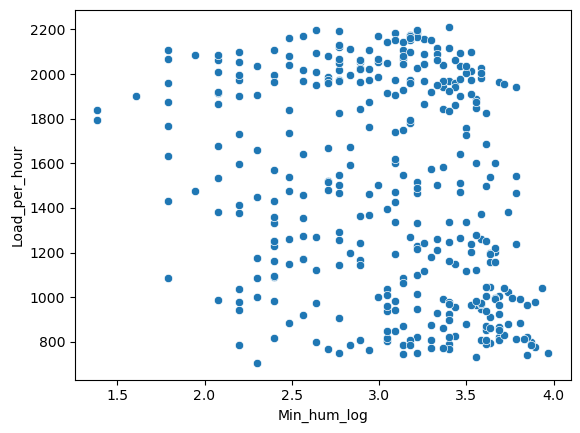

In [206]:
sns.scatterplot(data=df_lm, x='Min_hum_log', y='Load_per_hour')

Still no correlation seen form the plot, it's better to drop this variable from analysis.

In [207]:
df_lm.drop(['Min_hum_log', 'Min_hum'], axis=1, inplace=True)

#### Multicollinearity

Multicollinearity means high correlation between one or more predictor.

In [208]:
df_lm.corr()

,Avg_temp,Load_per_hour,1,2,3,4,5,6
Avg_temp,1.000000,0.962936,0.003019,-0.001069,-0.031049,0.006129,0.017119,-0.002432
Load_per_hour,0.962936,1.000000,0.013576,0.005299,0.008665,0.020977,0.009635,-0.051478
1,0.003019,0.013576,1.000000,-0.167742,-0.167742,-0.165854,-0.165854,-0.167742
2,-0.001069,0.005299,-0.167742,1.000000,-0.167742,-0.165854,-0.165854,-0.167742
3,-0.031049,0.008665,-0.167742,-0.167742,1.000000,-0.165854,-0.165854,-0.167742
4,0.006129,0.020977,-0.165854,-0.165854,-0.165854,1.000000,-0.163987,-0.165854
5,0.017119,0.009635,-0.165854,-0.165854,-0.165854,-0.163987,1.000000,-0.165854
6,-0.002432,-0.051478,-0.167742,-0.167742,-0.167742,-0.165854,-0.165854,1.000000


No high correlation between predictor detected.

### 1.2 Model Building

Train test split

In [209]:
from sklearn.model_selection import train_test_split

X = df_lm.drop('Load_per_hour', axis=1)
y = df_lm['Load_per_hour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [210]:
model_lm = sm.OLS(y_train, X_train).fit()
y_pred = model_lm.predict(X_test)
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:          Load_per_hour   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     508.5
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          1.63e-155
Time:                        08:06:14   Log-Likelihood:                -1813.9
No. Observations:                 289   AIC:                             3644.
Df Residuals:                     281   BIC:                             3673.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -717.0721     41.991    -17.077      0.0

In [211]:
from sklearn.metrics import mean_squared_error

lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'model LM RMSE is {lm_rmse}')

model LM RMSE is 115.15920163044865


### 1.3 Another Model Assumption

<Axes: >

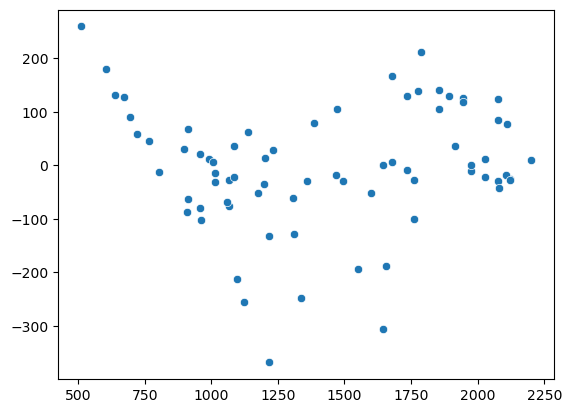

In [212]:
resid_val = y_test - y_pred

sns.scatterplot(y=resid_val, x=y_pred)

#### Linearity

From previous model evaluation, continuous predictor already have linear relationship with predictor, but in the result plot between y_hat with each term in linear regression (error), especially in the beginning of the plot, there's negative correlation, which means model cannot capture some pattern in the data.

#### Homoscedasticity (no Heteroscedasticity)

Homoscedasticity also being violated in this analysis, since the variance of error is not same in all observations.

#### Multivariate Normality

Multivariate normality states that the distribution of residual must be normally distributed.

Text(0.5, 0, 'Model Residual')

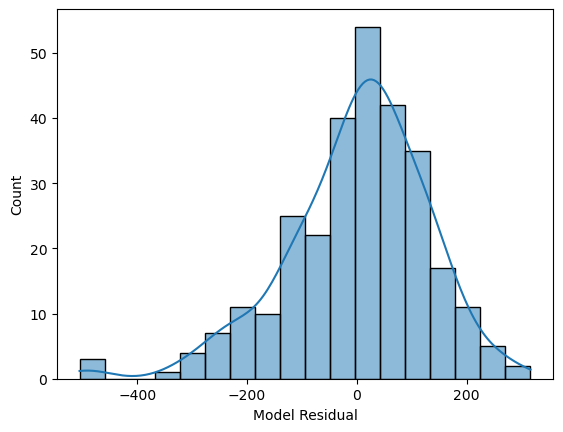

In [213]:
sns.histplot(model_lm.resid, kde=True)
plt.xlabel('Model Residual')

From plot above we can said that our residual have left skew (not normally distributed), but this assumption (normality) will have it's power for small data (10 observation each predictor or least), so for bigger data like we have, it is just a rule of thumb.

#### No Autocorrelation

This assumption states that the residual should be independent from one another. To check this assumption we can use Durbin-Watson test. Durbin watson test will calculate the presence of autocorrelaton in **lag 1** of the residual. The Durbin Watson test condition is:
- Null Hypothesis: There's no autocorrelation of errors
- Alternative Hypothesis: There's autocorrelation of errors

The value of Durbin Watson test will laid between 0-4, value between 1.8-2.2 means no autocorrelation, less than 1.8 means positive autocorrelation, while bigger than 2.2 indicate negative autocorrelation.

In [214]:
from statsmodels.stats.stattools import durbin_watson

#test = durbin_watson(model_lm.resid)
print(f'The value of Durbin Watson test is {durbin_watson(model_lm.resid):.2f}')

The value of Durbin Watson test is 1.83


No autocorrelation detected

## 2. K-Nearest Neightbors

### 2.1 Data Preparation

In [215]:
df_kmeans = df.copy()
# Choose only necessary columns
df_kmeans = df_kmeans[['Avg_temp', 'Avg_hum', 'Load_per_hour', 'Day_num']]
# Using one hot encoding in categorical data
day_encoder = pd.get_dummies(df_kmeans['Day_num'], drop_first=True)
df_kmeans.drop('Day_num', axis=1, inplace=True)
df_kmeans = df_kmeans.join(day_encoder)
# Renaming column name for scaling puposes
df_kmeans = df_kmeans.rename(columns={1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri'})

#### Train Test Split

In [216]:
X = df_kmeans.drop('Load_per_hour', axis=1)
y = df_kmeans['Load_per_hour']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2 Ensuring all data scales (X_train and X_test) are uniform

In [217]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[['Avg_temp', 'Avg_hum']])
def scaling(df):
    num_feature = df[['Avg_temp', 'Avg_hum']]
    num_scaled = scaler.transform(num_feature)
    df_num_scaled = pd.DataFrame(num_scaled, columns=num_feature.columns, index=df.index)
    df_scaled = pd.concat([df_num_scaled, df.drop(columns=num_feature.columns)], axis=1)
    return df_scaled

X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test)

### 2.3 Model Building

Different from previous model, K-Means Clustering doesn't need any assumtion for it's model. Besides, the selection of the number of K is very crucial, lower K means outliers will have higher impact than bigger number of K. And also, bigger value of K will result higher number of cluster. If it's too big, the model will over fit and the computational process will take longer.


Another things we should take a note is, K-NN calculating the distance around the target variable, which means the scale of the predictor must be close one to each other.

Find the best K number

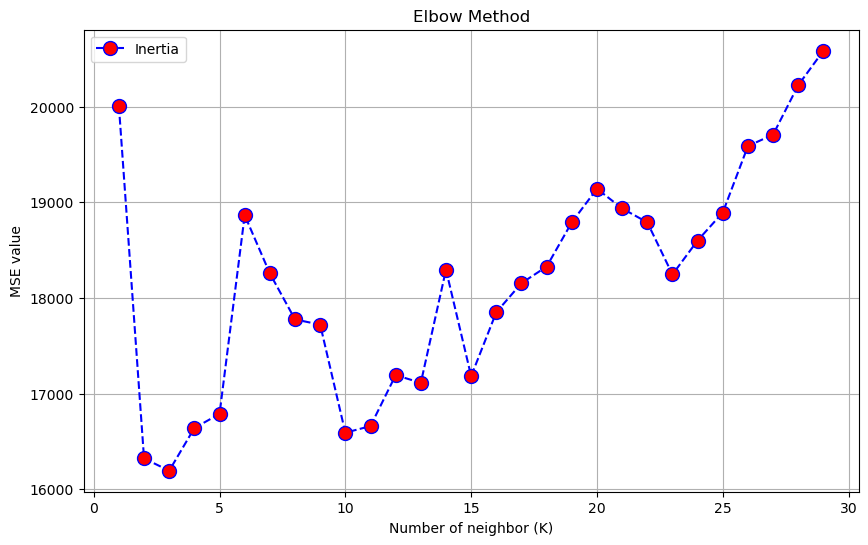

In [218]:
from sklearn.neighbors import KNeighborsRegressor

# We will use elbow method to look for the best K number

mse_values = []
for k in range(1, 30):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    mse_values.append(mean_squared_error(y_test, y_pred))
    
   
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), mse_values, color='blue', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=10, label='Inertia')
plt.title("Elbow Method")
plt.xlabel("Number of neighbor (K)")
plt.ylabel("MSE value")
plt.legend()
plt.grid()
plt.show()

The optimum number of K is 3, but, instead have the most lowest MSE number, the error is still too high compared to the scale of target variable. The reason is our data only have 3 predictors, and 1 of them have least significatn impact to the target variable.

In [220]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'model KNN RMSE is {knn_rmse}')

model KNN RMSE is 127.25875795562332


## 3. ARIMA and SARIMA

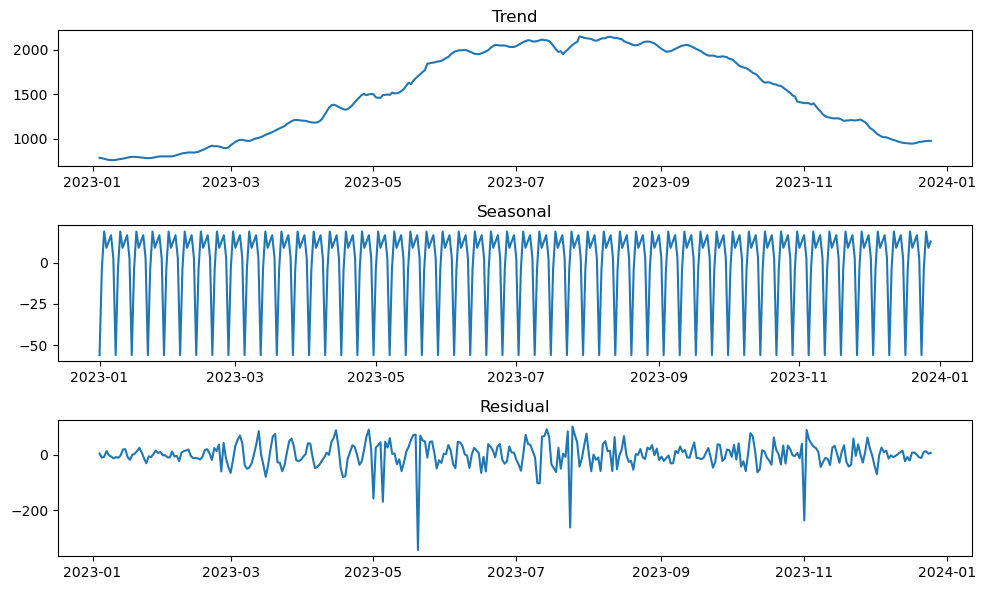

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
ax[0].plot(decomposition.trend)
ax[0].set_title('Trend')
ax[1].plot(decomposition.seasonal)
ax[1].set_title('Seasonal')
ax[2].plot(decomposition.resid)
ax[2].set_title('Residual')

plt.tight_layout()

In [44]:
# Ratio of seasonal amplitude to variance of the data

seasonal_max = decomposition.seasonal.max()
seasonal_min = decomposition.seasonal.min()

data_max = df['Load_per_hour'].max()
data_min = df['Load_per_hour'].min()

seasonal_amplitude = seasonal_max - seasonal_min
data_range = data_max - data_min

ratio = seasonal_amplitude / data_range
print(f'The amplitude ratio of the seasonal data is: {ratio:.2f}')


The amplitude ratio of the seasonal data is: 0.05


The ratio of seasonal amplitude to variance of the data is really low, it's indicate that seasoanl has low effect in to the data, or in other word, ARIMA model might be have better performance than SARIMA. But we will use both of the model to compare which model have better performance.

### 3.1 ARIMA

First, we need to determine the best parameter for the model, p (AR) which stand for how big the past data effeting present data. d (I), which means the number of the lag to achieve stationarity. Last is q (MA), is how big the effect of past error effecting present data.

#### I (d) or stationerity

Recall our observed data

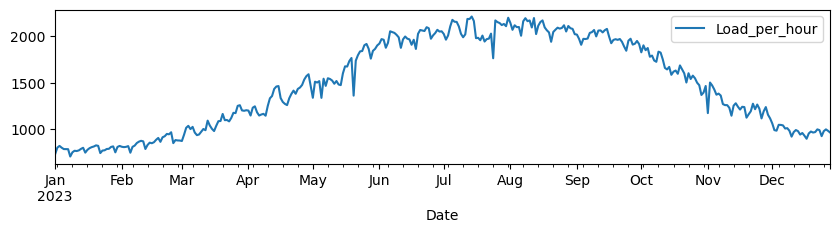

In [45]:
dtime.plot(figsize=(10,2))
plt.show()

Clearly the data is not stationer, also it has parabolic pattern.

In [46]:
# Test for stationarity
# It is obvius that our data is not stationer at all (it's mean and variance not same at all observation)
# but we will use Augmented Dickey Fuller Test to check it's stationarity
# Null Hypothesis: Time Series data is not stationer
# Alternative Hypothesis: Time Series data is stationer

from statsmodels.tsa.stattools import adfuller

adf = dtime['Load_per_hour']

adf_test  = adfuller(adf, regression='ctt') # 'cct' means 'constant, linear and quadratic trend'
print(f'ADF statistics: {adf_test[0]:.2f}')
print(f'p-value: {adf_test[1]:.2f}')

ADF statistics: -2.87
p-value: 0.36


p-value is not significant, hence we fail to reject the null hyphothesis, or the data is not stationer. We will use differencing to obtain stationarity in the data. Usually the maximum value of d is 2, above that, data will loose too many useful information.

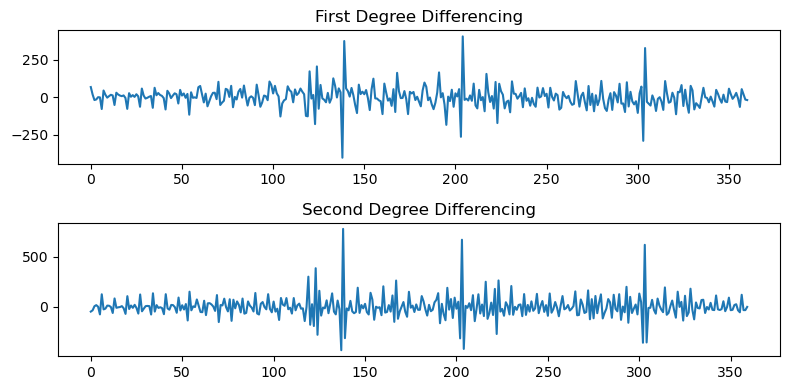

In [47]:
adf_1 = np.diff(adf)
adf_2 = np.diff(adf, n=2)

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(adf_1)
ax[0].set_title('First Degree Differencing')
ax[1].plot(adf_2)
ax[1].set_title('Second Degree Differencing')
plt.tight_layout()

In [48]:
# ADF test
adf_test = adfuller(adf_1, regression='c')
print(f'ADF statistics: {adf_test[0]:.2f}')
print(f'p-value: {adf_test[1]:.2f}')

ADF statistics: -3.24
p-value: 0.02


In [49]:
# KPSS test
kpss_test = sm.tsa.stattools.kpss(adf_1, regression='c')
print(f'KPSS statistics: {kpss_test[0]:.2f}')
print(f'p-value: {kpss_test[1]:.2f}')

KPSS statistics: 0.89
p-value: 0.01


Based on ADF and KPSS test, using first degree of differentiation the data is already stationer (d=1).

#### AR (p) or how past data effecting present data 

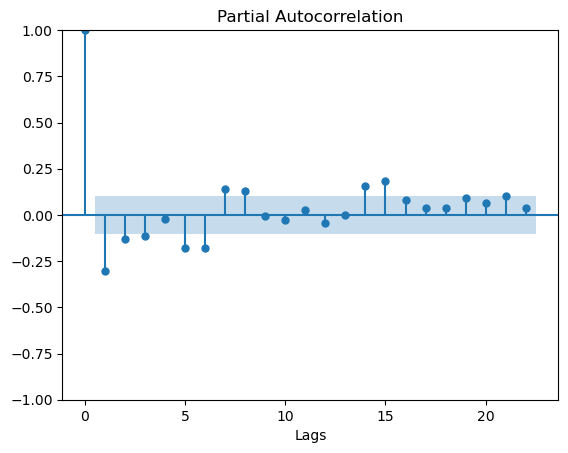

In [50]:
# Using ACF plot from matplotlib

sm.graphics.tsa.plot_pacf(adf_1, lags=22)
plt.xlabel("Lags")
plt.show()

#### MA (q) or how past error effecting present data 

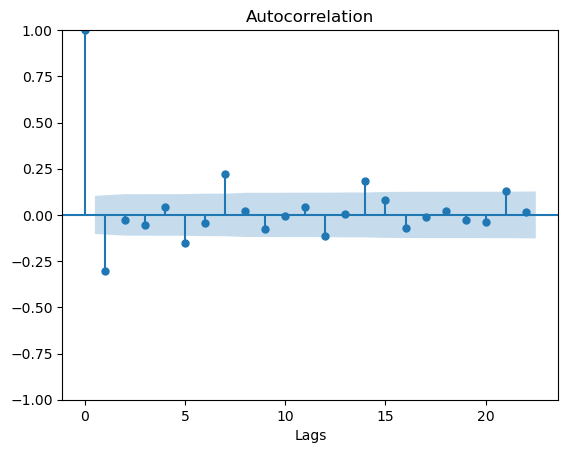

In [51]:
sm.graphics.tsa.plot_acf(adf_1, lags=22)
plt.xlabel("Lags")
plt.show()

Conclusion for ARIMA parameter :
- d = 1
- p = 1
- q = 1

#### Model Building

To get better output, we will use 2 arima model, first by using parameter we already determined before, and second using auto arima and let the system determine the best paramter for the model.

In [52]:
# Determined parameter
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

dtime_arima = dtime.copy()

tcsv = TimeSeriesSplit(n_splits=5)
for fold, (train_index, test_index) in enumerate(tcsv.split(dtime_arima)):
    train_data, test_data = dtime_arima.iloc[train_index], dtime_arima.iloc[test_index]
    
    # Model ARIMA
    arima_model = ARIMA(train_data['Load_per_hour'], order=(1, 1, 1))
    model_fit = arima_model.fit()
    arima_forecast = model_fit.forecast(steps=len(test_data))
    
    # Model Evaluation
    arima_rmse =  np.sqrt(mean_squared_error(test_data['Load_per_hour'], arima_forecast))
    arima_aic = model_fit.aic
    
    print(f'Fold {fold}, RMSE: {arima_rmse:.2f}, AIC: {arima_aic:.2f}')

Fold 0, RMSE: 328.01, AIC: 613.71
Fold 1, RMSE: 404.70, AIC: 1282.87
Fold 2, RMSE: 97.02, AIC: 2029.33
Fold 3, RMSE: 315.25, AIC: 2734.67
Fold 4, RMSE: 354.09, AIC: 3391.51


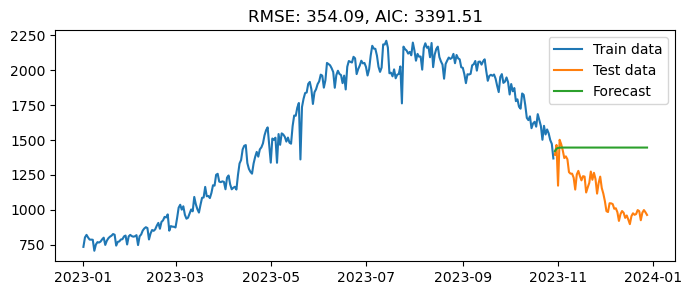

In [53]:
plt.figure(figsize=(8, 3))
plt.plot(train_data, label="Train data")
plt.plot(test_data, label="Test data")
plt.plot(arima_forecast, label="Forecast")
plt.title(f"RMSE: {arima_rmse:.2f}, AIC: {arima_aic:.2f}")
plt.legend()
plt.show()

In [54]:
# Using auto_arima
from pmdarima import auto_arima

auto_model = auto_arima(
    dtime_arima['Load_per_hour'],
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4448.383, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4285.515, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4446.385, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4226.114, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4180.582, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4174.853, Time=0.14 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4168.507, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4166.509, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4172.855, Time=0.07 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=4051.193, Time=0.33 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=4066.073, T

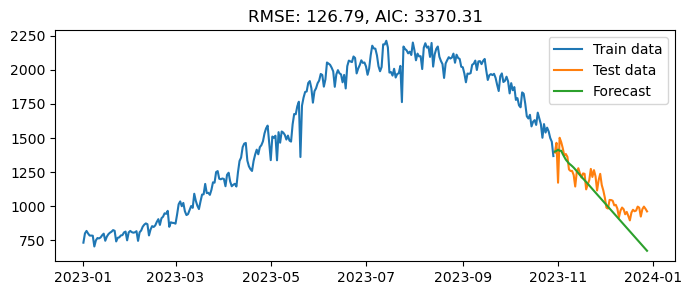

In [55]:
# Using the best paramter by auto_arima

auto_arima_model = ARIMA(train_data['Load_per_hour'], order=(5, 2, 2))
model_fit = auto_arima_model.fit()
auto_arima_forecast = model_fit.forecast(steps=len(test_data['Load_per_hour']))
auto_arima_rmse =  np.sqrt(mean_squared_error(test_data['Load_per_hour'], auto_arima_forecast))
auto_arima_aic = model_fit.aic

plt.figure(figsize=(8, 3))
plt.plot(train_data, label="Train data")
plt.plot(test_data, label="Test data")
plt.plot(auto_arima_forecast, label="Forecast")
plt.title(f'RMSE: {auto_arima_rmse:.2f}, AIC: {auto_arima_aic:.2f}')
plt.legend()
plt.show()

As we expected, ARIMA model will have good performance with data that have linear (or nearly linear) trend composition. The reason why the ARIMA reasult only showing straight line for both manual and auto_arima is because the model fail to capture the trend of the data. 

For manual ARIMA, we use d = 1 which is enough to made the model stationer, but somehow the model cant capture another usefull information of the data (because the trend is parabolic). As well as for both p and q numbers, we only use 1 lag (1 past data) and 1 error (1 error of past data) to do prediction, so, if the result of the first prediction is just a flat line, or something with big error, the remaining result will have same shape and the error will increasing bigger and bigger.

Same thing happened with auto_arima. The model only capture just a little pattern at the first prediction, but after that, we only have straight line. We weill try to use SARIMA and prophet to see if the model can make good prediction of the data.

### 3.2 SARIMAX

SARIMA have almost same parameter as ARIMA does. Another parameter are P, D, Q and S. where S is seasona pattern, P is seasonal autoregressive component or seasonal lag that have influence with current data, Q is seasonal moving average or seasonal error term that has influence with current data, D is seasonal differencing to achieve stationerity.

#### Seasonal Pattern (S)

It is obvius that the seasonal pattern is cycling every 7 days (S = 7)

#### I (D)

In order to determine D, we need to do seasonal differencing on non-seasonal differenced data.

In [56]:
differencing = dtime.copy()
# Non-seasonal differencing
non_seasonal_diff = differencing.diff(periods=1)
# Seasonal differencing using 7 lags
seasonal_diff = non_seasonal_diff.diff(periods = 7)
# Drop any NaN values
seasonal_diff = seasonal_diff.dropna()

ADF test after seasonal differencing

In [57]:
adf_test = adfuller(seasonal_diff, regression='c')
print(f'ADF statistics: {adf_test[0]:.2f}')
print(f'p-value: {adf_test[1]}')

ADF statistics: -9.82
p-value: 5.220848876632583e-17


KPSS test after seasonal differencing

In [58]:
kpss_test = sm.tsa.stattools.kpss(seasonal_diff, regression='c')
print(f'KPSS statistics: {kpss_test[0]:.2f}')
print(f'p-value: {kpss_test[1]}')

KPSS statistics: 0.04
p-value: 0.1


Text(0.5, 1.0, 'First Degree Differencing')

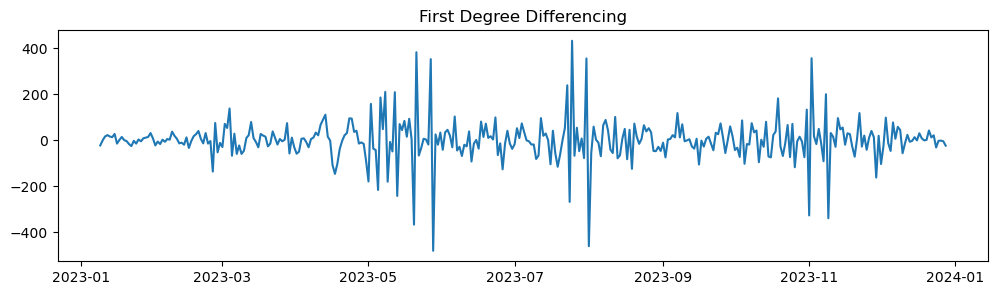

In [59]:
plt.figure(figsize=(12,3))
plt.plot(seasonal_diff)
plt.title('First Degree Differencing')

No obvious seasonal patter is visible

D = 1

#### AR (P)

We can use ACF plot to determine P value by seeing into seasonal lag (in our cas is 7), if the first 7 lag is significant, than P will be 1, if the significant lag is on second 7 lag (lag 14), then P is 2 and so on.

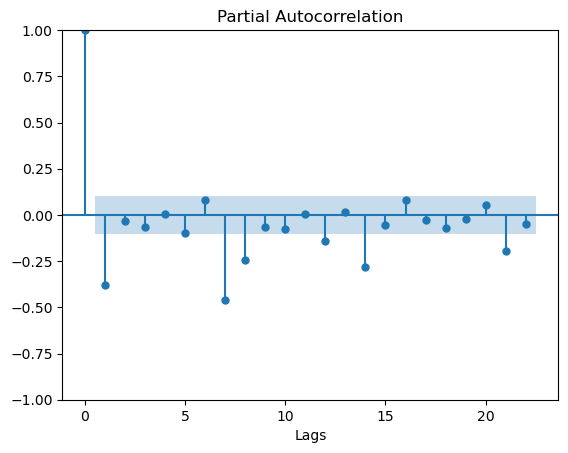

In [60]:
# PACF plot

sm.graphics.tsa.plot_pacf(seasonal_diff, lags=22)
plt.xlabel("Lags")
plt.show()

P = 1

#### MA (Q)

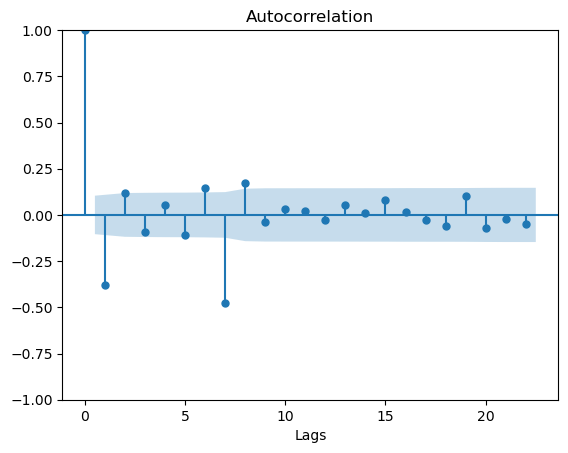

In [61]:
# Recall our ACF plot

sm.graphics.tsa.plot_acf(seasonal_diff, lags=22)
plt.xlabel("Lags")
plt.show()

Q = 1

#### Model Building

Our data have more than one columns (multivariate time series), it means we can use other columns, beside our taget data, as exogenous variable.

#### Using Manual Parameter

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Choose some columns as endo and exsog variable
sarimax = df[['Load_per_hour', 'Date', 'Avg_temp', 'Avg_hum']]

# Using time series split to see model performance
tcsv = TimeSeriesSplit(n_splits=5)
for fold, (train_index, test_index) in enumerate(tcsv.split(sarimax)):
    train_data, test_data = sarimax.iloc[train_index], sarimax.iloc[test_index]
    
    # Model SARIMAX
    sarimax_model = SARIMAX(
        endog=train_data['Load_per_hour'], 
        exog=train_data[['Avg_temp', 'Avg_hum']], 
        order=(1, 1, 1), 
        seasonal_order=(1, 1, 1, 7)
    )
    model_fit = sarimax_model.fit()
    
    # Forecasting
    sarimax_forecast = model_fit.forecast(
        steps = len(test_data),
        exog = test_data[['Avg_temp', 'Avg_hum']])
    
    # Model Evaluation
    sarimax_rmse =  np.sqrt(mean_squared_error(test_data['Load_per_hour'], sarimax_forecast))
    sarimax_aic = model_fit.aic
    
    print(f'Fold {fold}, RMSE: {sarimax_rmse:.2f}, AIC: {sarimax_aic:.2f}')

Fold 0, RMSE: 202.89, AIC: 510.64
Fold 1, RMSE: 103.76, AIC: 1171.46
Fold 2, RMSE: 176.89, AIC: 1917.83
Fold 3, RMSE: 385.94, AIC: 2619.76
Fold 4, RMSE: 169.95, AIC: 3250.94


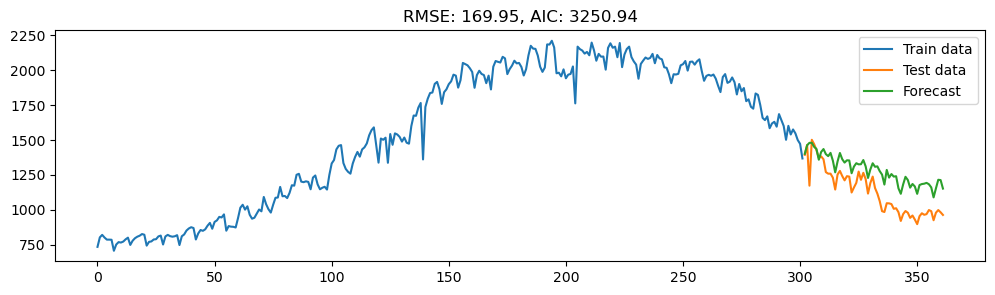

In [63]:
# Plotting forecasting result
plt.figure(figsize=(12, 3))
plt.plot(train_data['Load_per_hour'], label="Train data")
plt.plot(test_data['Load_per_hour'], label="Test data")
plt.plot(sarimax_forecast, label="Forecast")
plt.title(f'RMSE: {sarimax_rmse:.2f}, AIC: {sarimax_aic:.2f}')
plt.legend()
plt.show()

#### Using auto_arima

In [ ]:
y = df['Load_per_hour']
X = df[['Avg_temp']]

auto_model = auto_arima(
    y = y,
    X = X,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,
    d=None, D=None, # Let the model detect it automatically
    m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=3984.431, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4103.177, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4038.808, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4029.955, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4101.204, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=4028.901, Time=0.32 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=4023.724, Time=0.23 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=3988.620, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=4039.783, Time=0.17 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=4017.921, Time=0.47 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=4010.634, Time=0.40 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=3988.226, Time=1.11 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3983.184, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : 

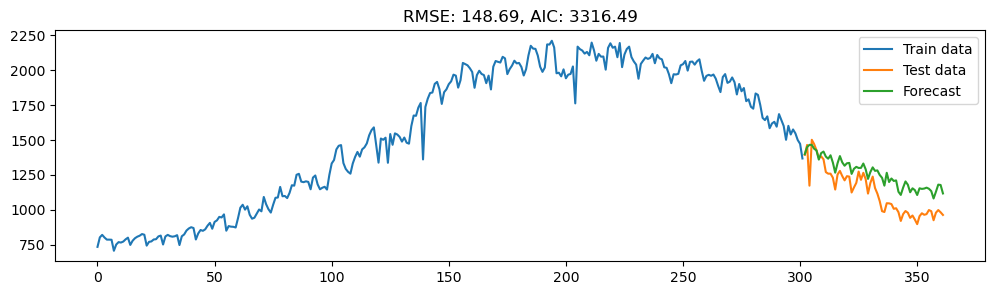

In [65]:
# SARIMAX model
sarimax_model2 = SARIMAX(
    endog=train_data['Load_per_hour'], 
    exog=train_data[['Avg_temp', 'Avg_hum']], 
    order=(0, 1, 1), 
    seasonal_order=(1, 0, 1, 7)
    )

# Model fit
model2_fit = sarimax_model2.fit()

# Forecasting
result = model2_fit.forecast(
        steps = len(test_data),
        exog = test_data[['Avg_temp', 'Avg_hum']])

# RMSE and AIC as model evaluation
rmse2 =  np.sqrt(mean_squared_error(test_data['Load_per_hour'], result))
aic2 = model2_fit.aic

# Plotting the forecast result
plt.figure(figsize=(12, 3))
plt.plot(train_data['Load_per_hour'], label="Train data")
plt.plot(test_data['Load_per_hour'], label="Test data")
plt.plot(result, label="Forecast")
plt.title(f'RMSE: {rmse2:.2f}, AIC: {aic2:.2f}')
plt.legend()
plt.show()

Only slight different between manual and auto arima model, it's hard to tell which model is better. Manual SARIMAX model have lower number of AIC, means the model is much optimum to get the balance between complexity of parameters and log likelihood (much simpler). But, our aim in this analysis is to get lower error of prediction, we dont want to interpret the model or relation between independet and dependent variable, so we will choose the model with lower RMSE.

## 4. Prophet

Prophet is open source machine learning for forecasting made by facebook data science core team. For some cases, prophet will give more flexibility compared to SARIMAX, it can detect holiday effect, changepoint, change prior scale, etc. It worked under sklearn API, so first we make the model variable, fit, and than do forecasting. This package also have built in plot that help us to plot the model result.

Before that, as we saw before, our data seems has 3 abnormal value on the data that increasing the error of the model, they are at 20 May, 24 July and 1 November. I can't get any information what was happened in those three days. So for educational purpose, I will remove this 3 values and replace them with value using moving avarege.

#### Replacing abnormal value

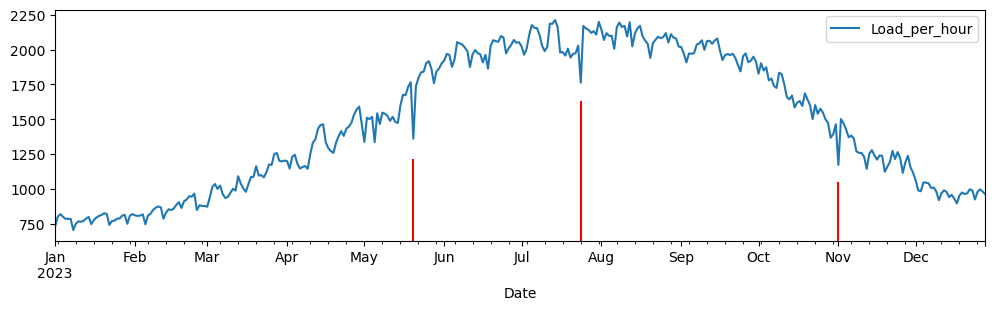

In [66]:
# Recall our plot
dtime.plot(figsize=(12, 3))
# Pointing where abnormal value is
plt.axvline(x = '2023-05-20', ymax=0.35, color='red') 
plt.axvline(x = '2023-07-24', ymax=0.6, color='red')
plt.axvline(x = '2023-11-01', ymax=0.25, color='red')

<Axes: xlabel='Date'>

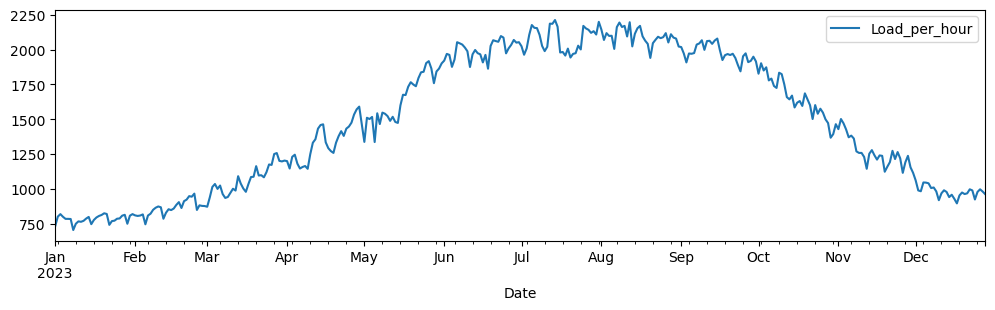

In [67]:
prophet_df = dtime.copy()
# Replace all abnormal value with nan
prophet_df.loc[['2023-05-20', '2023-07-24', '2023-11-01']] = np.nan
# Calculate moving average
ma = prophet_df.rolling(window=3, min_periods=1).mean()
# Replave NaN with moving average value
prophet_df = prophet_df.fillna(value=ma)
prophet_df.plot(figsize=(12, 3))

The plot is more reasonable now

Prophet requires the time series data to only have 2 columns, date time and observed value columns. Also we need to rename the date time column to `ds`, and observed column to `y`, and it's recommended to use the format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.

In [68]:
prophet_df = prophet_df.reset_index().rename(columns={'Date':'ds', 'Load_per_hour':'y'})

Train test split

In [69]:
border_date = "2023-10-31"
train = (prophet_df['ds'] <= border_date)
test = (prophet_df['ds'] > border_date)
prophet_train = prophet_df.loc[train]
prophet_test = prophet_df.loc[test]

In [70]:
# Train test split
prophet_train.tail()

,ds,y
299,2023-10-27,1500.0
300,2023-10-28,1473.0
301,2023-10-29,1368.0
302,2023-10-30,1394.0
303,2023-10-31,1465.0


#### Prophet model with no tuning parameter.

In [71]:
from prophet import Prophet
from prophet.plot import plot_plotly

In [72]:
# Create instance for prophet model
prophet_model = Prophet()
# Fit the model
prophet_model.fit(prophet_train)

06:44:05 - cmdstanpy - INFO - Chain [1] start processing
06:44:06 - cmdstanpy - INFO - Chain [1] done processing


Unlike any other model where the model automatically give us a list of forecasting result, in prophet, we need to create new data frame with only ds column, this data frame containing our history date and extention of date based on specified pariods. But we don't need to create it manually, prophet can make it automatically using `make_future_dataframe()` function.

In [73]:
future_date = prophet_model.make_future_dataframe(periods=58, freq='D')
future_date.tail()

,ds
357,2023-12-24
358,2023-12-25
359,2023-12-26
360,2023-12-27
361,2023-12-28


In [74]:
# Forecasting
prophet_forecast = prophet_model.predict(future_date)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2023-01-01,674.982921,593.686149,752.864195
1,2023-01-02,732.679346,650.146937,815.499525
2,2023-01-03,752.110056,669.519674,829.217365
3,2023-01-04,753.440689,669.248408,836.156738
4,2023-01-05,755.997881,679.095262,843.777854


Prophet return alot of interesting columns, but for now this 4 columns is the most important among the others. `yhat` is predicted value, `yhat_lower` the lower bound of forecast, and `yhat_upper` the upper bound of forecast.

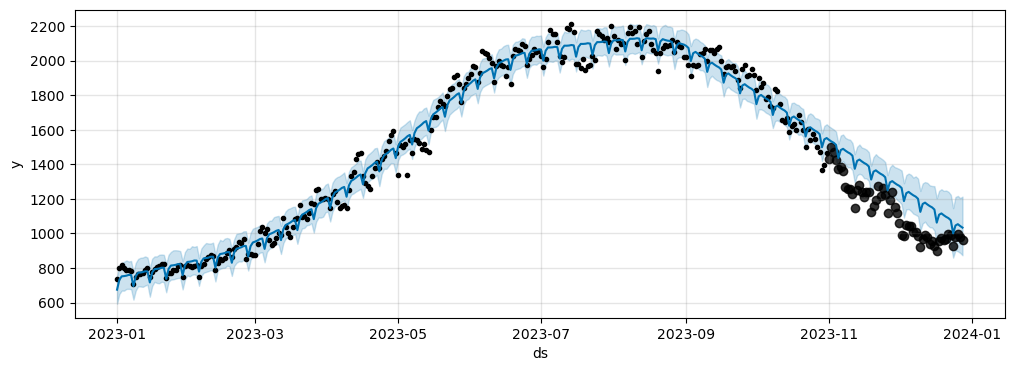

In [75]:
fig, ax = plt.subplots(figsize=(12,4))
prophet_model.plot(prophet_forecast, uncertainty=True, ax=ax)
ax.scatter(prophet_test['ds'], prophet_test['y'], color='black', label='Test Data', alpha=0.8)
plt.show()

Prophet plotting the observed value as black dot, the forecast value as blue line, and uncetainty intervals as blue shades. Let's try tuning the model to get better result.

#### Prophet model with tuning parameter

In [76]:
# Add regressor
# Regressor need to be present in both the fitting and prediction dataframes.
prophet_df2 = prophet_df.copy()
future_date2 = future_date.copy()
prophet_df2[['Avg_temp', 'Avg_hum']] = df[['Avg_temp', 'Avg_hum']]
future_date2[['Avg_temp', 'Avg_hum']] = df[['Avg_temp', 'Avg_hum']]

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
import logging
import warnings

# Turn off log prophet
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet').setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

# Determining change point and seasonality flexibility
param_grid = {'changepoint_prior_scale' : [0.001, 0.01, 0.1, 0.5], # Adjust change point flexibility
              'seasonality_prior_scale' : [0.01, 0.1, 1.0, 10.0], # Adjust seasonaluty felxibility
              'weekly_seasonality' : [2, 3, 4, 5]} # Adjusting fourier order

# Make all possible parameter combination
all_params = [dict(zip(param_grid.keys(), i)) for i in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params, yearly_seasonality=False, daily_seasonality=False)
    m.add_regressor('Avg_temp')
    m.add_regressor('Avg_hum')
    m.fit(prophet_df2)
    df_cv = cross_validation(m, horizon='58 days')
    df_p = performance_metrics(df_cv, rolling_window=0.1) # Using 10% of the horizon to averaging the RMSE
    rmses.append(df_p['rmse'].values[0])
    
# Finding the best parameter
tuning_result = pd.DataFrame(all_params)
tuning_result['rmse'] = rmses
best_params = all_params[np.argmin(rmses)]
print(best_params)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'weekly_seasonality': 5}


In [79]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'weekly_seasonality': 5}


#### Create modoel using the best parameter

In [80]:
# Additional regressor for both data train and test
prophet_train[['Avg_temp', 'Avg_hum']] = df[df['Date'] <= border_date][['Avg_temp', 'Avg_hum']]
prophet_test[['Avg_temp', 'Avg_hum']] = df[df['Date'] > border_date][['Avg_temp', 'Avg_hum']]

In [81]:
prophet_model2 = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10.0, weekly_seasonality=5, daily_seasonality=False,
                         yearly_seasonality=False)
prophet_model2.add_regressor('Avg_temp')
prophet_model2.add_regressor('Avg_hum')
prophet_model2.fit(prophet_train)
df_cv = cross_validation(prophet_model2, horizon='58 days')
df_p = performance_metrics(df_cv, rolling_window=0.1)

  0%|          | 0/3 [00:00<?, ?it/s]

In [94]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
48,54 days,83894.303943,289.645135,264.603928,0.152970,0.105775,0.139081,0.666667
49,55 days,89996.189394,299.993649,273.216794,0.158686,0.119820,0.143670,0.666667
50,56 days,99039.091705,314.704769,286.380002,0.169158,0.119820,0.151982,0.666667
51,57 days,106180.786667,325.853935,300.152205,0.179281,0.136621,0.160528,0.666667
52,58 days,114494.182029,338.369889,313.894741,0.188903,0.139067,0.168571,0.666667


The rmse value is getting bigger over time (overfit deteceted)

#### Forecasting

In [88]:
# Make future data frame
future = prophet_model2.make_future_dataframe(periods=58, freq='D')
# Additional regressor must be present in both fitting and future df
future[['Avg_temp', 'Avg_hum']] = df[['Avg_temp', 'Avg_hum']]
# Forecasting
forecast = prophet_model2.predict(future)

#### Plotting some important componenets

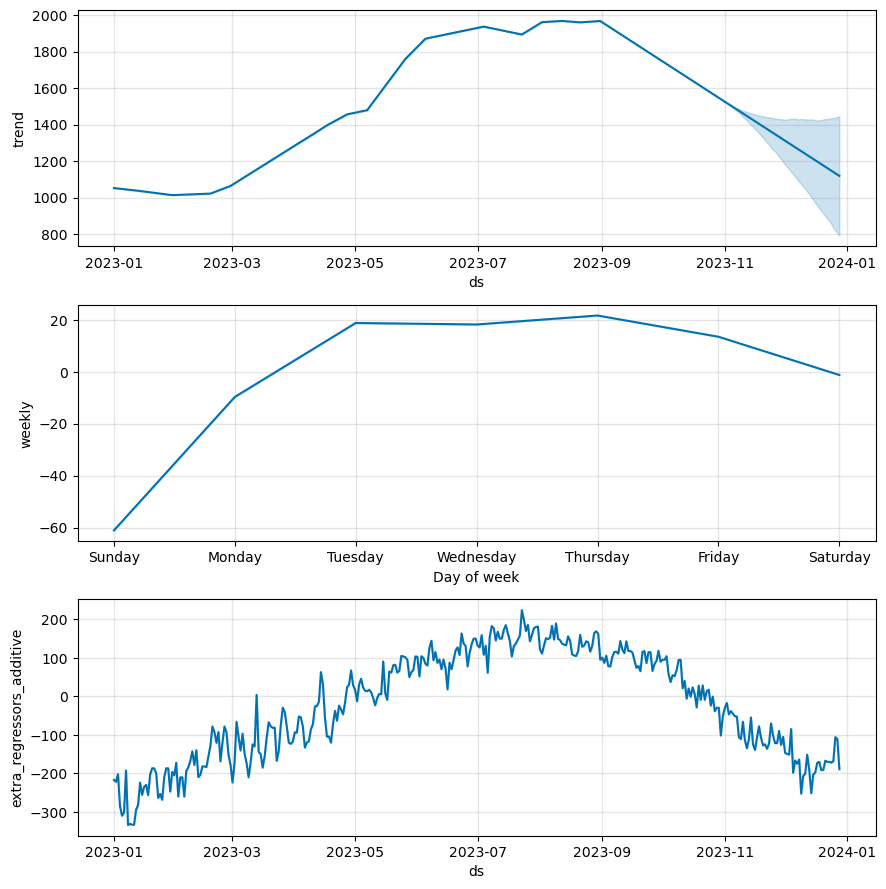

In [90]:
from prophet.plot import add_changepoints_to_plot
fig = prophet_model2.plot_components(forecast)

From plot above we can say even we use grid search to find the best parameter for the model, the trend captured by the model is still far from the observed data (still have high error). From weekly components we know that thursday is the highest electricity consumed among the other day of the week.

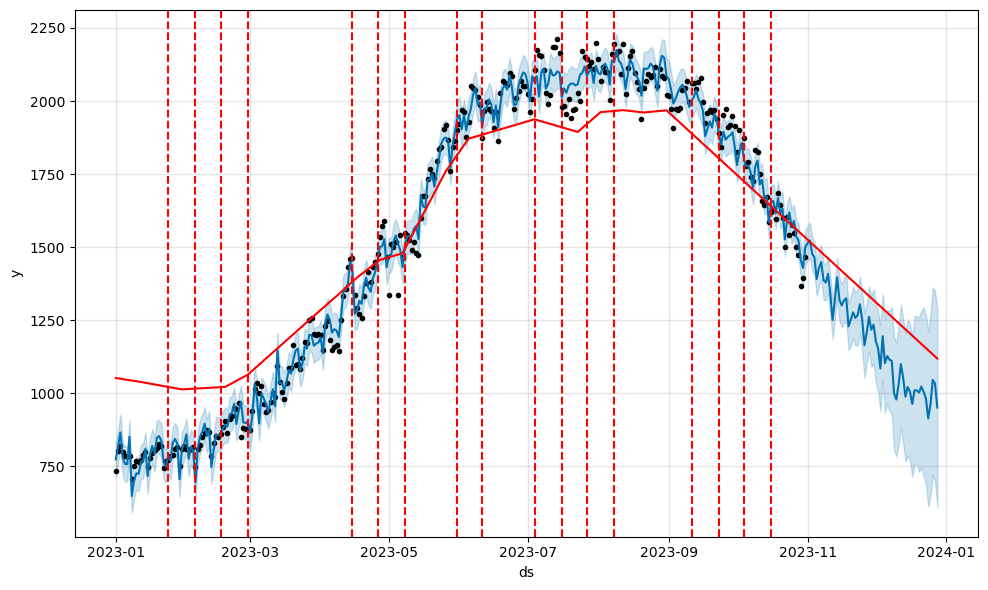

In [92]:
fig = prophet_model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Prophet will automatically detect 25 change points of the data, and using spars prior, our model will only left 17 change points that have the biggest impact to the data (most significant) based on L1 regularization.

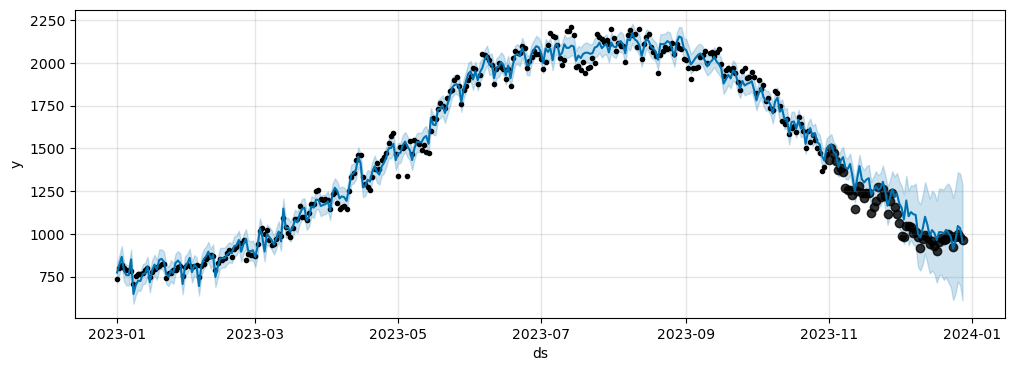

In [95]:
fig, ax = plt.subplots(figsize=(12,4))
prophet_model2.plot(forecast, uncertainty=True, ax=ax)
ax.scatter(prophet_test['ds'], prophet_test['y'], color='black', label='Test Data', alpha=0.8)
plt.show()

In [99]:
y_true = prophet_test['y']
y_pred = forecast.iloc[-58:]['yhat']
prophet_model2_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Final prophet model RMSE: {prophet_model2_rmse:.2f}')

Final prophet model RMSE: 78.03


# Conclusion

### Comparing all RMSE value

In [236]:
rmse_value = [lm_rmse, knn_rmse, auto_arima_rmse, rmse2, prophet_model2_rmse]
model_name = ['Linear Regression', 'K-NN', 'SARIMA', 'SARIMAX', 'Prophet']

d = {'Model name':model_name, 'RMSE':rmse_value}
pd.DataFrame(d)

,Model name,RMSE
0,Linear Regression,115.159202
1,K-NN,127.258758
2,SARIMA,126.787244
3,SARIMAX,148.693745
4,Prophet,78.033307


Among all models, Prophet has best performance based on RMSE values. Some of the reasong:

- Linear regression fail to made good prediction was the present of Endogenaity or lack of important variable, we only use 2 parameters and one of the have low correlation with target variable.
- K-NN have same reason as linear regression model, where predictor we used cannot explain the target variable well.
- SARIMA model is good for the data with linear trend, and also our model seems have weekly seasonal pattern which SARIMA model cannot handle.
- SARIMAX also good for the model with linear trend, this model can also capture seasonal pattern presented in the data, also this model can use exsogen variable to capture another patter of the data. But our model have alot uncertainty causing the model fail to capture all the pattern.
- Prophet have the best performance among all the model because we have more flexibility to tuning it's parameters. We give more flexibility to the model about trend change, change point and also the trend pattern. But still, this model works better for univariate data with good knowledge of it, since we lack of information of the data (holliday, seasonality affected by another factor, etc) we cannot maximize the model performance.